In [177]:
from scipy.io import loadmat 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from BiSplineDer import BiSpline, UniBiSpline
data = loadmat(r"EQUIL_TCV_74310_1s.mat")


In [178]:
def IntSample(R, z, IntObjFunct):
    jmax = np.size(R)
    imax = np.size(z)
    s = np.empty([imax, jmax])
    s[:,:] = np.nan
    for i in range(imax):
        zloc = z[i]
        for j in range(jmax):
            Rloc = R[j]
            s[i,j] = IntObjFunct(Rloc, zloc)
    return s

In [179]:
import scipy.signal as signal

def butterworth(dat, n=3, Wn=0.1, fs=5):
    b, a = signal.butter(n, Wn, btype='low', fs=fs)
    # Apply the filter to xn.  Use lfilter_zi to choose the initial condition of the filter.
    # Wn is the cutoff frequency
    # fs is the sampling frequency
    
    return signal.filtfilt(b, a, dat)

In [180]:
unpacked_data = data['equil'][0][0]

In [181]:
unpacked_data.dtype.names

('psi_apRp',
 'theta',
 'ptx',
 'pty',
 'ptBx',
 'ptBy',
 'ptBP',
 'ptBPHI',
 'Rp',
 'Zp',
 'ptalpha',
 'ptgpsi',
 'x',
 'y',
 'xypsin',
 'psia',
 'Bx',
 'By',
 'BPHI',
 'rho_scr',
 'ne_scr',
 'Te_scr',
 'ne_err_scr',
 'Te_err_scr',
 'rho_eq',
 'pTe',
 'pne',
 'ne_avg',
 'rho_full',
 'ne_full',
 'Te_full',
 'ne_err_full',
 'Te_err_full',
 'zZi',
 'zmi',
 'fi',
 'pzTi',
 'pzni',
 'id')

In [182]:
# Unpack the data. There are two big groups, those expressed in terms of psi and those expressed in terms of R and Z

# Every variable on the psi theta grid gets a pt prefix, each variable on the R Z grid gets an rz prefix
#psi = np.array(unpacked_data['psi_apRp'][0])
#psi /= psi[-1]
rho = np.array(unpacked_data['rho_full'][0])
psi = rho**2
theta = np.array(unpacked_data['theta'][0])

npsi = len(psi)
nrho = len(rho)
ntheta = len(theta)

pt_psi = np.tile(psi, (ntheta, 1)).T
pt_rho = np.tile(rho, (ntheta, 1)).T
pt_theta = np.tile(theta, (npsi, 1))

# The correct R and Z coordinates are also needed:

#These are the coordinates of the magnetix axis
Rp = np.array(unpacked_data['Rp'][0][0])
Zp = np.array(unpacked_data['Zp'][0][0])

pt_R = np.array(unpacked_data['ptx'] + Rp)
pt_Z = np.array(unpacked_data['pty'] + Zp)

# Temperature and density are also useful. Both as 1D arrays and in 2D form
p_Te = unpacked_data['Te_full'][0]
p_ne = unpacked_data['ne_full'][0]
pt_Te = np.tile(p_Te, (ntheta, 1)).T
pt_ne = np.tile(p_ne, (ntheta, 1)).T

#Save the data to textfiles, will be extended beyond the last closed flux surface

np.savetxt('p_Te.txt', np.column_stack((rho, p_Te)))
np.savetxt('p_ne.txt', np.column_stack((rho, p_ne)))

# The magnetic field is also useful. It is given on the same poloidal grid as R and Z values

pt_B_R = np.array(unpacked_data['ptBx'])
pt_B_Z = np.array(unpacked_data['ptBy'])
pt_B_phi = np.array(unpacked_data['ptBPHI'])

# Now the other values are on a regular carthesian grid. This is what we'll need for WKBeam

R = np.array(unpacked_data['x'] + Rp)
Z = np.array(unpacked_data['y'] + Zp)


nR = len(R)
nZ = len(Z)

rz_R = np.tile(R, (1, nZ))
rz_Z = np.tile(Z, (1, nR)).T

rz_psi = np.array(unpacked_data['xypsin'])
rz_rho = np.sqrt(rz_psi)
rz_rho_max = np.max(rz_rho)

rz_B_R = np.array(unpacked_data['Bx'])
rz_B_Z = np.array(unpacked_data['By'])
rz_B_phi = np.array(unpacked_data['BPHI'])


In [183]:
rz_rho_max

1.2859761134092937

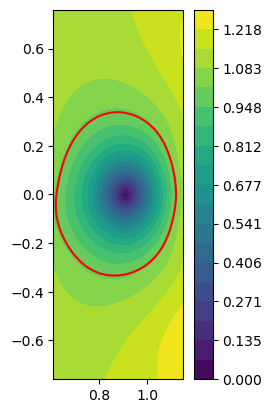

In [184]:
max_psi = np.max(rz_psi)
fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_aspect('equal')
rzgrid = ax.contourf(rz_R, rz_Z, rz_rho, levels=np.linspace(0, rz_rho_max, 20))
plt.colorbar(rzgrid)
ax.contour(rz_R, rz_Z, rz_rho, levels=[1], colors='r')


In [185]:
rz_psi_spline = BiSpline(R, Z, rz_psi)
rz_rho_spline = BiSpline(R, Z, np.sqrt(rz_psi))

pt_psi_approx = np.array([[rz_psi_spline.eval(pt_R[i,j], pt_Z[i,j]) for j in range(ntheta)] for i in range(41)])
pt_rho_approx = np.array([[rz_rho_spline.eval(pt_R[i,j], pt_Z[i,j]) for j in range(ntheta)] for i in range(41)])


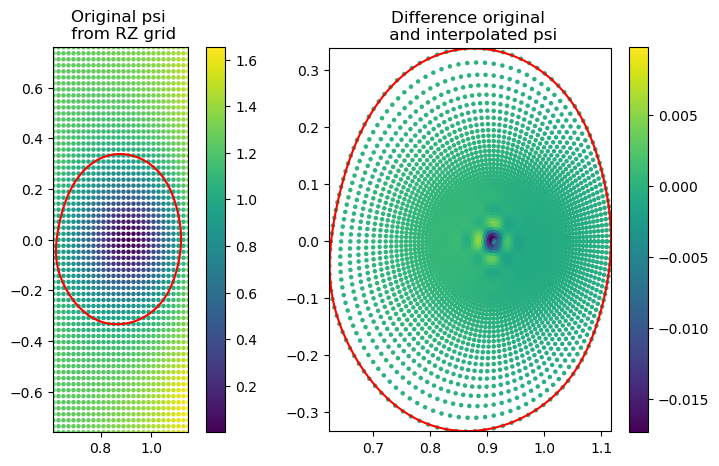

In [186]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.set_aspect('equal')
rzgrid = ax.scatter(rz_R, rz_Z, c=rz_psi, s=5)
ax.contour(rz_R, rz_Z, rz_psi[:41, :], levels=[1], colors='r')
ax.set_title('Original psi \n from RZ grid')
plt.colorbar(rzgrid)

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
rzgrid = ax2.scatter(pt_R, pt_Z, c=pt_rho_approx-pt_rho[:41, :], s=5)
ax2.contour(pt_R, pt_Z, pt_psi[:41, :], levels=[0.999], colors='r')
ax2.set_title('Difference original \n and interpolated psi')
plt.colorbar(rzgrid)

## Extended profiles, smoothed

In [187]:
import scipy.interpolate as spl

In [188]:
def profile_extrapolation_ed(rho, profile, rho_max, refinement=100):

    # First extend the ranges of rho and profile to include the region outside the last closed flux surface
    drho = rho[1]-rho[0] #assumes rho is a regular grid

    # We impose a true vacuum profile at two further rho steps away from the last data point. 
    rho_ext = np.concatenate((rho, np.arange(rho[-1] + 2*drho, rho_max, drho)))

    # From this vacuum position, we set the profile to zero before extrapolating
    profile_ext = np.concatenate((profile, np.zeros(len(rho_ext)-len(profile))))

    # Now we extrapolate the profile to the outside of the LCFS using a spline

    profile_spline = spl.UnivariateSpline(rho_ext, profile_ext, s=0)

    # In order to properly resolve the separatrix, we need to refine ur grid. Then we can smoothen the transition
    # A value of 100 for the refined grid is more or less a lower bound, otherwise the transition is too sharp

    # If you do change this value, it is perhaps also best to play with the butterworth filter parameters
    rho_ext_refined = np.linspace(rho[0], rho_max, refinement)
    profile_ext_refined = profile_spline(rho_ext_refined)

    # Now we smoothen the transition between the original profile and the extrapolated profile
    # The butterworth filter is a low pass filter, so it will smoothen the transition
    # The parameters are a bit arbitrary, but they seem to work well
    # Just the n=1 is a must
    profile_ext_refined = butterworth(profile_ext_refined, n=1, Wn=0.3, fs=2)

    #Now just a safety to make sure we don't have negative values. Also values that are too small are set to zero
    # to assure the demanded vacuum profile is imposed

    indices_to_zero = np.where(profile_ext_refined < 1e-3* profile_ext_refined.max())[0][0]
    profile_ext_refined[indices_to_zero:] = 0

    return rho_ext_refined, profile_ext_refined


In [189]:
rho_ext, Te_ext = profile_extrapolation_ed(rho, p_Te, rho_max=rz_rho_max)
rho_ext, ne_ext = profile_extrapolation_ed(rho, p_ne, rho_max=rz_rho_max)

In [190]:
p_Te_scr = unpacked_data['Te_scr'][0]
p_ne_scr = unpacked_data['ne_scr'][0]
p_rho_scr = np.array(unpacked_data['rho_scr'][0])

pe_Te_err_scr = unpacked_data['Te_err_scr'][0]
pe_ne_err_scr = unpacked_data['ne_err_scr'][0]



In [191]:
p_Te_err = unpacked_data['Te_err_full'][0]
p_ne_err = unpacked_data['ne_err_full'][0]

<ErrorbarContainer object of 3 artists>

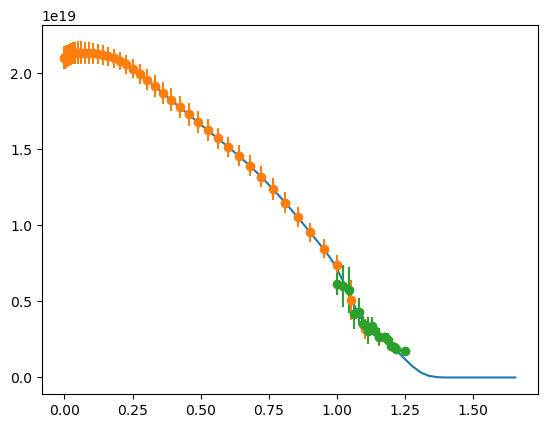

In [192]:
plt.plot(rho_ext**2, ne_ext)
plt.errorbar(rho**2, p_ne, yerr=p_ne_err, fmt='o')
plt.errorbar(p_rho_scr**2, p_ne_scr, yerr=pe_ne_err_scr, fmt='o')

In [193]:
rho_ext[np.where(ne_ext < 1e-3*ne_ext.max())]**2

array([1.39726313, 1.42814094, 1.45935621, 1.49090895, 1.52279915,
       1.55502681, 1.58759193, 1.62049452, 1.65373456])

In [194]:
rz_ne_spline = UniBiSpline(rho_ext, ne_ext, psi_interpolator=rz_psi_spline)
rz_ne = IntSample(R, Z, rz_ne_spline.eval).T
rz_ne = np.where(rz_ne < 1e-4* p_ne.max(), 0, rz_ne)

rz_Te_spline = UniBiSpline(rho_ext, Te_ext, psi_interpolator=rz_psi_spline)
rz_Te = IntSample(R, Z, rz_Te_spline.eval).T
rz_Te = np.where(rz_Te < 1e-4* p_Te.max(), 0, rz_Te)


Text(0.5, 1.0, 'Original Te \n from RZ grid')

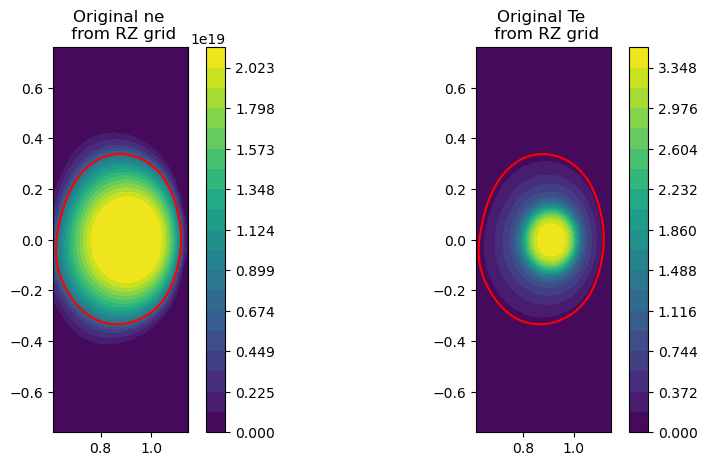

In [195]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.set_aspect('equal')
rzgrid = ax.contourf(rz_R, rz_Z, rz_ne, levels=np.linspace(0, p_ne.max(), 20))
plt.colorbar(rzgrid)
ax.contour(rz_R, rz_Z, rz_rho, levels=[1], colors='r')
ax.set_title('Original ne \n from RZ grid')

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
rzgrid = ax2.contourf(rz_R, rz_Z, rz_Te, levels=np.linspace(0, p_Te.max(), 20))
plt.colorbar(rzgrid)
ax2.contour(rz_R, rz_Z, rz_rho, levels=[1], colors='r')
ax2.set_title('Original Te \n from RZ grid')
